<a href="https://colab.research.google.com/github/brhwang0411/work_dept/blob/main/(WM)_Active_ETFs_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pykrx
!pip install -q fastdtw scipy
!pip install -q PyPDF2 openai


[한국형]
1. 타임폴리오의 ETF 들
https://www.timefolio.co.kr/etf/funds_list.php

1) TIMEFOLIO K바이오액티브 ETF (463050)
신약/바이오베터, 의료기기, 디지털 헬스케어 등 빠르게 진화하는 국내 바이오 헬스케어 핵심기업을 발굴 및 선별하여 집중 투자
2) TIMEFOLIO Kstock액티브 ETF (385720)
주도 섹터와 종목을 시의 적절하게 발굴하여 시장지수 대비 나은 성과를 추구하는 액티브 ETF입니다
3) TIMEFOLIO K컬처액티브 ETF (410870)
K-Pop, 영화, 드라마 등 컨텐츠와 미용 및 의료까지 아우르는 한국의 문화경쟁력에 투자하는 액티브 ETF입니다
4) TIMEFOLIO Korea플러스배당액티브 ETF (441800)
월배당과 코스피200 대비 초과 성과를 동시에 추구하는 액티브 ETF입니다

2. KoAct의 ETF 들
https://www.samsungactive.co.kr/etf/list.do

1) KoAct 바이오헬스케어액티브 (462900)
변화하는 바이오·헬스케어 산업, 이제 액티브하게 투자하세요!
2) KoAct 배당성장액티브 (476850)
미래 배당의 확대 가능성에 더 주목하여 한국 배당성장주에 투자하는 ETF
3) KoAct 테크핵심소재공급망액티브 (482030)
기술혁신과 함께 성장하는 국내 테크소재와 원재료공급망에 투자하는 ETF


In [ ]:
import matplotlib.pyplot as plt
from pykrx import stock
from datetime import datetime, timedelta
import pandas as pd
from fastdtw import fastdtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# 오늘 날짜를 YYYYMMDD 형식으로 가져오기
today = (datetime.now() - timedelta(days=4)).strftime("%Y%m%d")

# ETF 포트폴리오 구성 종목 가져오기
active_etf_pdf = stock.get_etf_portfolio_deposit_file("385720")
active_etf_pdf = active_etf_pdf[active_etf_pdf['계약수'] > 0]

# 시장 시가총액 정보 가져오기
mkt_cap_info = stock.get_market_cap(today)

# ETF 구성 종목 중 시가총액 정보가 있는 종목만 필터링
common_tickers = active_etf_pdf.index.intersection(mkt_cap_info.index)
filtered_active_etf_pdf = active_etf_pdf.loc[common_tickers]
filtered_mkt_cap_info = mkt_cap_info.loc[common_tickers]

# 종목명을 기준으로 ETF 포트폴리오와 시가총액 정보 병합
filtered_active_etf_pdf = filtered_active_etf_pdf.merge(filtered_mkt_cap_info[['시가총액']], left_index=True, right_index=True, how='left')

# 시가총액 정보가 없는 종목 제거
filtered_active_etf_pdf = filtered_active_etf_pdf.dropna(subset=['시가총액'])

total_mkt_cap = filtered_active_etf_pdf['시가총액'].sum()

# 시가총액 합계 중에 차지하는 비율 계산 및 추가
filtered_active_etf_pdf['시가총액_비중'] = filtered_active_etf_pdf['시가총액'] / total_mkt_cap * 100

filtered_active_etf_pdf['ActiveWeight'] = filtered_active_etf_pdf['비중'] - filtered_active_etf_pdf['시가총액_비중']

# 시각화를 위한 log화 진행
filtered_active_etf_pdf['Log_비중'] = np.log(1+filtered_active_etf_pdf['비중'])
filtered_active_etf_pdf['Log_시가총액_비중'] = np.log(1+filtered_active_etf_pdf['시가총액_비중'])

# ActiveWeight를 기준으로 정렬
filtered_active_etf_pdf = filtered_active_etf_pdf.sort_values(by='ActiveWeight', ascending=False)

print (filtered_active_etf_pdf)

           계약수         금액     비중             시가총액    시가총액_비중  ActiveWeight  \
티커                                                                           
003230    49.0   32781000   2.99    4986855930000   0.383038      2.606962   
257720   629.0   29563000   2.83    2918871570300   0.224197      2.605803   
161890   374.0   26628800   2.55    1723170621000   0.132356      2.417644   
267260    96.0   29760000   2.84   11499036065000   0.883235      1.956765   
009540   173.0   27472400   2.66   11146765770000   0.856177      1.803823   
241710   192.0   16224000   1.56     890712000000   0.068415      1.491585   
183300   197.0   15819100   1.55     863006430000   0.066287      1.483713   
145020    72.0   16632000   1.64    2917833639500   0.224117      1.415883   
138040   325.0   25707500   2.48   14475656652600   1.111867      1.368133   
214450   100.0   14880000   1.48    1626514192600   0.124932      1.355068   
036460   321.0   16756200   1.67    4901820300000   0.376506    

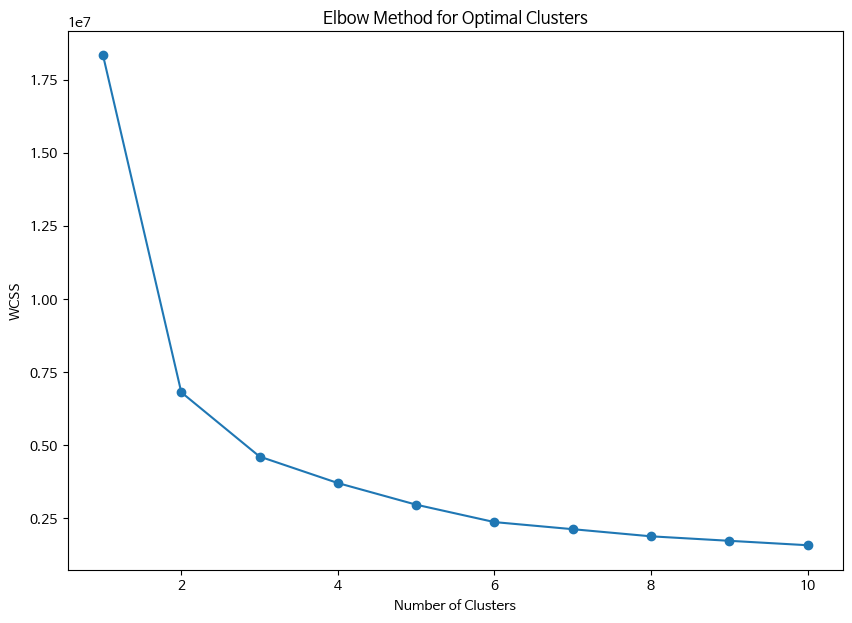

Clustered DataFrame:
           계약수         금액     비중             시가총액    시가총액_비중  ActiveWeight  \
티커                                                                           
051910    59.0   20384500   2.00   24283765992000   1.865223      0.134777   
006400    39.0   13806000   1.37   24823995330000   1.906718     -0.536718   
373220   104.0   33956000   3.40   76752000000000   5.895280     -2.495280   
035720   221.0    8983650   0.88   17913169312000   1.375901     -0.495901   
035420    88.0   14687200   1.39   26862381447600   2.063285     -0.673285   
207940    34.0   24718000   2.45   52099368000000   4.001725     -1.551725   
047050   221.0   14453400   1.39   11857195911200   0.910745      0.479255   
066570   168.0   18631200   1.82   17870341288800   1.372611      0.447389   
005490    47.0   17061000   1.67   30403357185000   2.335266     -0.665266   
078600    67.0    9581000   0.97    2328281187200   0.178834      0.791166   
034020   490.0    9849000   0.95   12740761

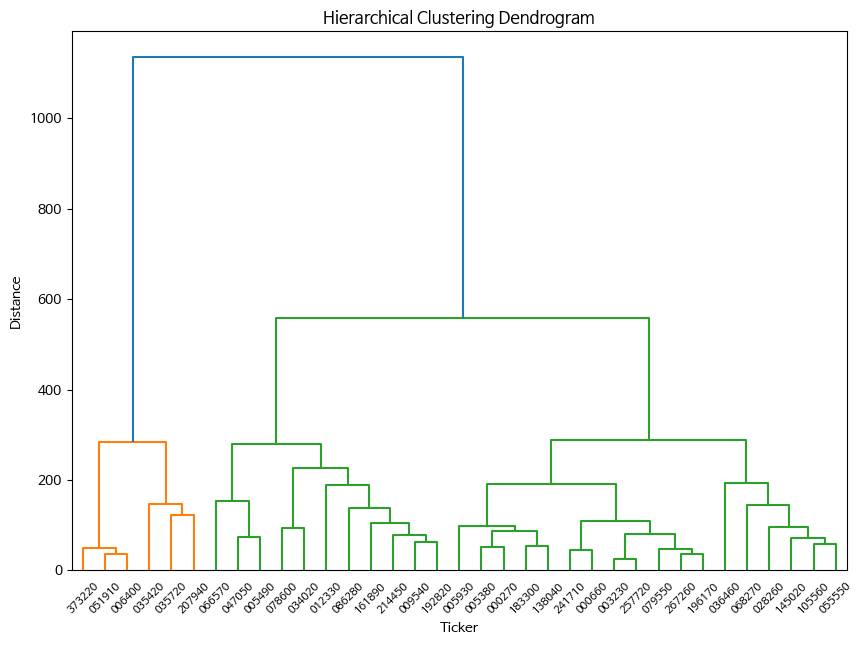

In [ ]:
# 클러스터링을 위한 데이터 준비
prices = {}
for ticker in filtered_active_etf_pdf.index:
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    prices[ticker] = df['종가'].values

# 주가 데이터 정규화
scaler = StandardScaler()
normalized_prices = {ticker: scaler.fit_transform(price.reshape(-1, 1)).flatten() for ticker, price in prices.items()}

# 동적 시간 왜곡을 이용한 거리 계산
tickers = list(normalized_prices.keys())
distance_matrix = np.zeros((len(tickers), len(tickers)))

for i in range(len(tickers)):
    for j in range(i, len(tickers)):
        if i != j:
            distance, _ = fastdtw(normalized_prices[tickers[i]], normalized_prices[tickers[j]])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

# 클러스터링 수행
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
def calculate_wcss(linkage_matrix, max_clusters=10):
    wcss = []
    for t in range(1, max_clusters + 1):
        clusters = fcluster(linkage_matrix, t=t, criterion='maxclust')
        centroids = []
        for cluster in range(1, t + 1):
            cluster_points = [distance_matrix[i] for i in range(len(clusters)) if clusters[i] == cluster]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
        total_distance = 0
        for i in range(len(clusters)):
            cluster = clusters[i]
            centroid = centroids[cluster - 1]
            total_distance += np.sum((distance_matrix[i] - centroid) ** 2)
        wcss.append(total_distance)
    return wcss

wcss = calculate_wcss(linkage_matrix)

# 엘보우 방법 그래프 시각화
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# 최적의 클러스터 수 자동 결정
optimal_clusters = np.argmin(np.diff(wcss, 2)) + 2

# 최적의 클러스터 수를 사용하여 클러스터 할당
clusters = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')
filtered_active_etf_pdf['Cluster'] = clusters

# 클러스터 및 ActiveWeight를 기준으로 정렬
filtered_active_etf_pdf = filtered_active_etf_pdf.sort_values(by=['Cluster', 'ActiveWeight'], ascending=[True, False])

# 클러스터 결과 출력
print("Clustered DataFrame:")
print(filtered_active_etf_pdf)

# 덴드로그램 시각화
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=tickers)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Ticker')
plt.ylabel('Distance')
plt.show()

In [ ]:
# 각 클러스터별로 ActiveWeight가 가장 높은 종목 추출
top_stocks_per_cluster = filtered_active_etf_pdf.groupby('Cluster').head(1).reset_index()

# 결과 출력
print("Top Stocks per Cluster:")
print(top_stocks_per_cluster[['티커', 'Cluster', 'ActiveWeight', '시가총액', '비중', '시가총액_비중']])

Top Stocks per Cluster:
       티커  Cluster  ActiveWeight            시가총액    비중   시가총액_비중
0  051910        1      0.134777  24283765992000  2.00  1.865223
1  035720        2     -0.495901  17913169312000  0.88  1.375901
2  047050        3      0.479255  11857195911200  1.39  0.910745
3  078600        4      0.791166   2328281187200  0.97  0.178834
4  161890        5      2.417644   1723170621000  2.55  0.132356
5  003230        6      2.606962   4986855930000  2.99  0.383038
6  145020        7      1.415883   2917833639500  1.64  0.224117


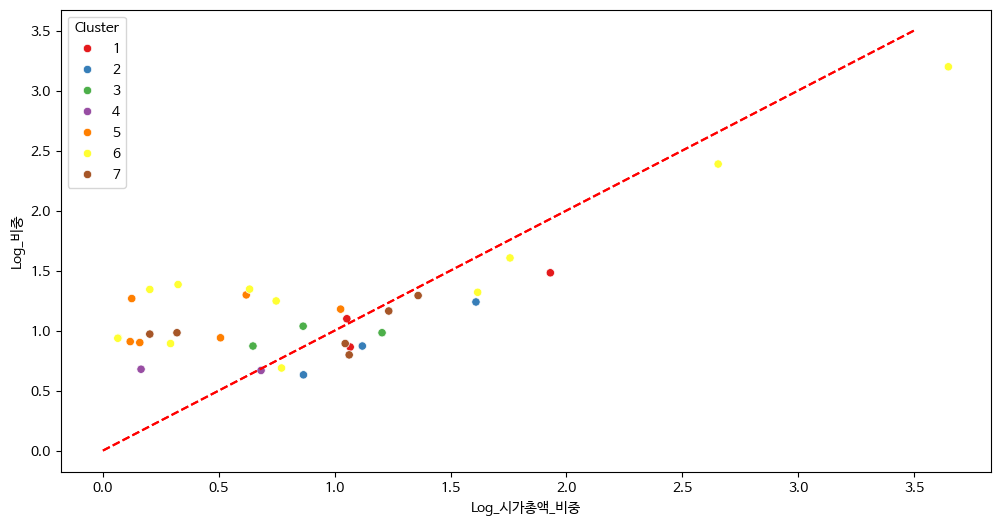

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=filtered_active_etf_pdf, y='Log_비중', x='Log_시가총액_비중', hue='Cluster', palette='Set1')

y_x_values = np.linspace((0,0),(3.5,3.5))
plt.plot(y_x_values, y_x_values, color='red', linestyle='--')

### IDEA1. 푸리에 변환 베이스의 Denoised
- 푸리에 변환을 통해 시계열 데이터의 노이즈 제거
- 단발성의 가격 변화에 보다 robust 한 경향을 보임
- 각 군집별 평균 distance도 기존 방식보다 멀어짐을 확인

<Axes: >

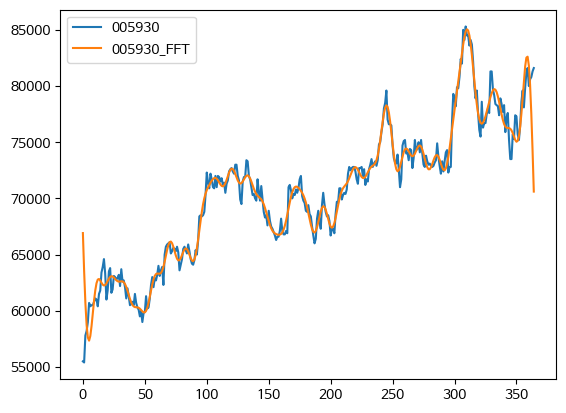

In [ ]:
## FFT 예시
def FFT(df, col, topn=30):
    fft = np.fft.fft(df[col])
    fft[topn:-topn] = 0
    ifft = np.fft.ifft(fft)
    return ifft

test = pd.DataFrame(prices)
test['005930_FFT'] = FFT(test, '005930')
test[['005930', '005930_FFT']].plot()

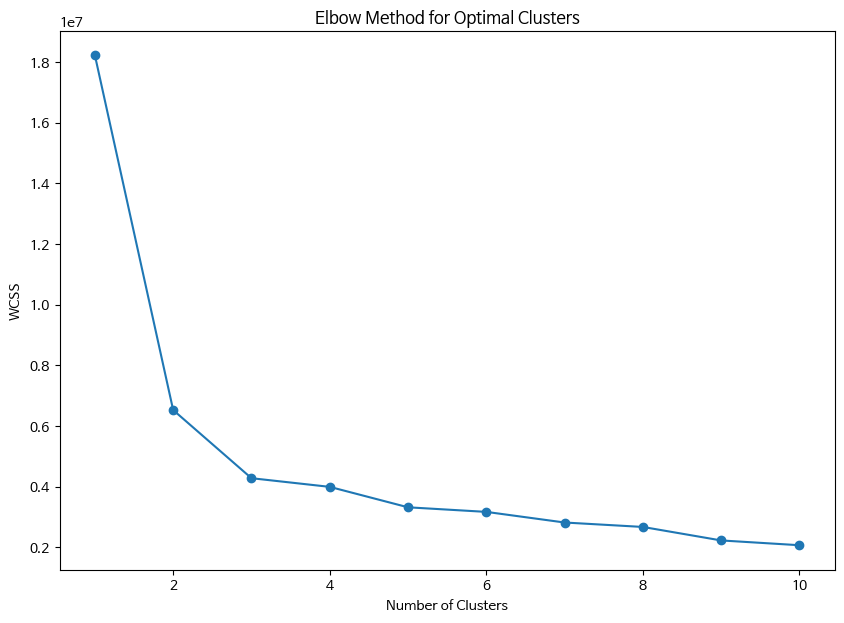

Clustered DataFrame:
           계약수         금액     비중             시가총액    시가총액_비중  ActiveWeight  \
티커                                                                           
066570   168.0   18631200   1.82   17870341288800   1.372611      0.447389   
051910    59.0   20384500   2.00   24283765992000   1.865223      0.134777   
035720   221.0    8983650   0.88   17913169312000   1.375901     -0.495901   
006400    39.0   13806000   1.37   24823995330000   1.906718     -0.536718   
035420    88.0   14687200   1.39   26862381447600   2.063285     -0.673285   
207940    34.0   24718000   2.45   52099368000000   4.001725     -1.551725   
373220   104.0   33956000   3.40   76752000000000   5.895280     -2.495280   
003230    49.0   32781000   2.99    4986855930000   0.383038      2.606962   
257720   629.0   29563000   2.83    2918871570300   0.224197      2.605803   
267260    96.0   29760000   2.84   11499036065000   0.883235      1.956765   
241710   192.0   16224000   1.56     890712

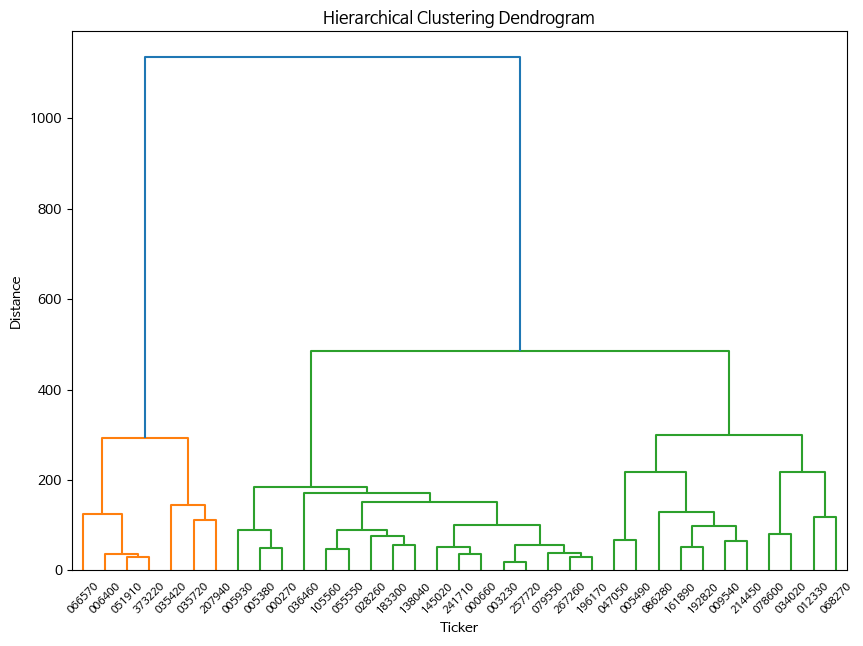

In [ ]:
# 클러스터링을 위한 데이터 준비
prices = {}
for ticker in filtered_active_etf_pdf.index:
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    df['종가_FFT'] = FFT(df, '종가') ## 종가에 대한 Denoising 진행
    prices[ticker] = df['종가_FFT'].values

# 주가 데이터 정규화
# 푸리에 변환을 하는 경우 실수와 허수가 나뉘게 되어 각자 scaling
scaler_real = StandardScaler()
scaler_imag = StandardScaler()
normalized_prices = {}
for ticker, price in prices.items():
    real_price = np.real(price).reshape(-1,1)
    imag_price = np.imag(price).reshape(-1,1)

    real_price_scaled = scaler_real.fit_transform(real_price).flatten()
    imag_price_scaled = scaler_imag.fit_transform(imag_price).flatten()

    norm_fft_values = real_price_scaled + 1j * imag_price_scaled
    normalized_prices[ticker] = norm_fft_values


# 동적 시간 왜곡을 이용한 거리 계산
tickers = list(normalized_prices.keys())
distance_matrix = np.zeros((len(tickers), len(tickers)))

for i in range(len(tickers)):
    for j in range(i, len(tickers)):
        if i != j:
            distance, _ = fastdtw(normalized_prices[tickers[i]], normalized_prices[tickers[j]])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

# 클러스터링 수행
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
def calculate_wcss(linkage_matrix, max_clusters=10):
    wcss = []
    for t in range(1, max_clusters + 1):
        clusters = fcluster(linkage_matrix, t=t, criterion='maxclust')
        centroids = []
        for cluster in range(1, t + 1):
            cluster_points = [distance_matrix[i] for i in range(len(clusters)) if clusters[i] == cluster]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
        total_distance = 0
        for i in range(len(clusters)):
            cluster = clusters[i]
            centroid = centroids[cluster - 1]
            total_distance += np.sum((distance_matrix[i] - centroid) ** 2)
        wcss.append(total_distance)
    return wcss

wcss = calculate_wcss(linkage_matrix)

# 엘보우 방법 그래프 시각화
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# 최적의 클러스터 수 자동 결정
optimal_clusters = np.argmin(np.diff(wcss, 2)) + 2

# 최적의 클러스터 수를 사용하여 클러스터 할당
clusters = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')
filtered_active_etf_pdf['Cluster'] = clusters

# 클러스터 및 ActiveWeight를 기준으로 정렬
filtered_active_etf_pdf = filtered_active_etf_pdf.sort_values(by=['Cluster', 'ActiveWeight'], ascending=[True, False])

# 클러스터 결과 출력
print("Clustered DataFrame:")
print(filtered_active_etf_pdf)

# 덴드로그램 시각화
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=tickers)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Ticker')
plt.ylabel('Distance')
plt.show()

In [ ]:
# 각 클러스터별로 ActiveWeight가 가장 높은 종목 추출
top_stocks_per_cluster = filtered_active_etf_pdf.groupby('Cluster').head(1).reset_index()

# 결과 출력
print("Top Stocks per Cluster:")
print(top_stocks_per_cluster[['티커', 'Cluster', 'ActiveWeight', '시가총액', '비중', '시가총액_비중']])

Top Stocks per Cluster:
       티커  Cluster  ActiveWeight            시가총액    비중   시가총액_비중
0  066570        1      0.447389  17870341288800  1.82  1.372611
1  003230        2      2.606962   4986855930000  2.99  0.383038
2  161890        3      2.417644   1723170621000  2.55  0.132356
3  078600        4      0.791166   2328281187200  0.97  0.178834


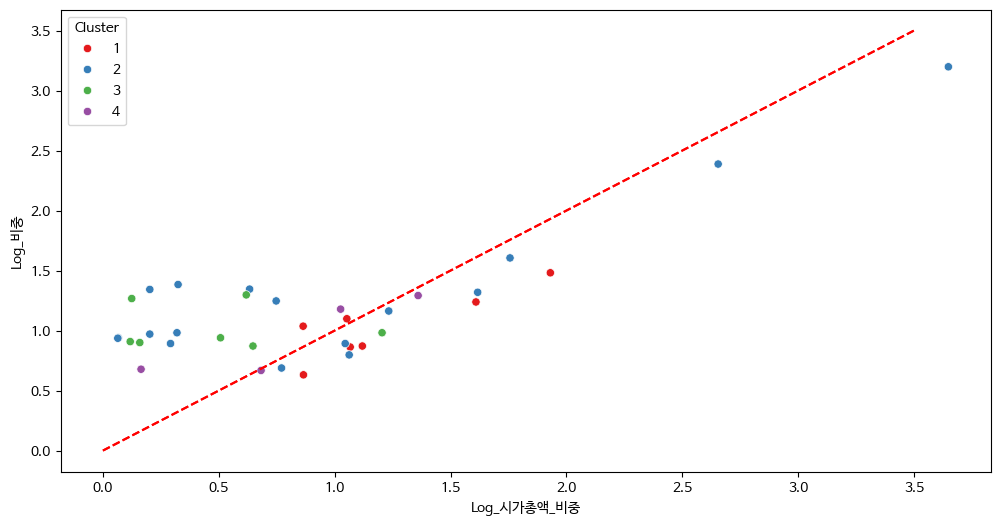

In [ ]:
filtered_active_etf_pdf['Log_비중'] = np.log(1+filtered_active_etf_pdf['비중'])
filtered_active_etf_pdf['Log_시가총액_비중'] = np.log(1+filtered_active_etf_pdf['시가총액_비중'])

plt.figure(figsize=(12,6))
sns.scatterplot(data=filtered_active_etf_pdf, y='Log_비중', x='Log_시가총액_비중', hue='Cluster', palette='Set1')

y_x_values = np.linspace((0,0),(3.5,3.5))
plt.plot(y_x_values, y_x_values, color='red', linestyle='--')

### IDEA2. Hurst Exponent 테스트 기반의 모멘텀/회귀 경향성
- Hurst Exponent 테스트를 통해 회귀성이 강한 종목인지 모멘텀이 강한 종목인지 추출(0.5 이하면 회귀, 이상이면 모멘텀)
- Hurst 지수값과 Active Weight(0을 기준), 둘을 기준으로 4개의 세그먼트 분리
- 해석 예시
  - Hurst 값이 0.5 이상이면서 Active Weight가 0 초과인 그룹: 가격 모멘텀이 강하고 해당 ETF에서 시총 비중 이상으로 공격적 투자
- 장점: 비전문가(고객)에게도 설명하기 쉬움
- 단점: 별도의 클러스터링 모델을 사용하지 않고 직접적인 Threshold 값을 사용했다는 게 단점

In [ ]:
def hurst_exponent(time_series, max_lag=20):
    lags = range(2, max_lag)
    time_series = np.log(time_series)
    tau = [np.std(np.array(time_series[lag:] - np.array(time_series[:-lag]))) for lag in lags]
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

prices = {}
for ticker in filtered_active_etf_pdf.index[:1]: ## 예시를 위해 한 종목(삼성전자)만 추출
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    prices[ticker] = df['종가'].values

test = pd.DataFrame(prices)
hurst_exponent(test) ## 해당 값이 0.5보다 작을수록 평균회귀 경향이 강한 종목, 0.5보다 클수록 모멘텀 경향이 강한 종목

0.45708078826752463

<Axes: xlabel='ActiveWeight', ylabel='HurstExponent'>

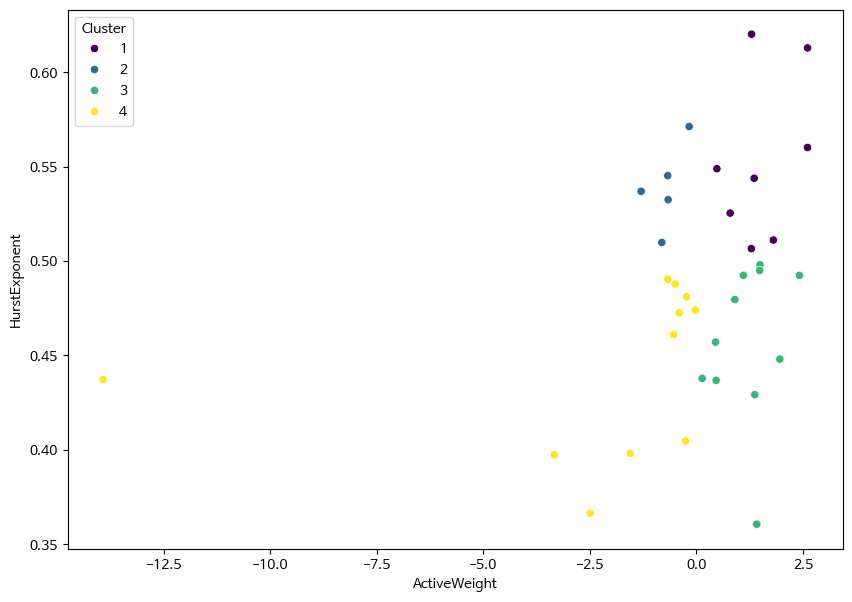

In [ ]:
hurst_values = []
for ticker in filtered_active_etf_pdf.index:
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    hurst_values.append(hurst_exponent(df['종가'].values))

filtered_active_etf_pdf['HurstExponent'] = hurst_values
hurst_exponent_pos = filtered_active_etf_pdf['HurstExponent'] >= 0.5
active_weight_pos = filtered_active_etf_pdf['ActiveWeight'] >= 0

filtered_active_etf_pdf['Cluster'] = np.select(
    [active_weight_pos & hurst_exponent_pos,
    ~active_weight_pos & hurst_exponent_pos,
    active_weight_pos & ~hurst_exponent_pos,
    ~active_weight_pos & ~hurst_exponent_pos],
    [1,2,3,4],
    default = 0
)

plt.figure(figsize=(10, 7))
sns.scatterplot(filtered_active_etf_pdf, x='ActiveWeight', y='HurstExponent', hue='Cluster', palette='viridis')

### IDEA3. Riskfolio 라이브러리 활용
- riskfolio 외부 라이브러리를 활용하면 HRP를 비롯한 다양한 방식의 클러스터링 모델 사용 가능
- 다양한 기법&방식의 클러스터링 모듈을 테스트하기에 좋음
- 시각화 툴도 잘 갖춰진 라이브러리
- 최종적으로 DHBT 알고리즘 기반의 클러스터링이 가장 괜찮은 성능을 보임
  - DHBT: Direct Hierarchical Bubble Tree
  - 참고: https://riskfolio-lib.readthedocs.io/en/latest/auxiliary.html

In [ ]:
!pip install Riskfolio-Lib

[]

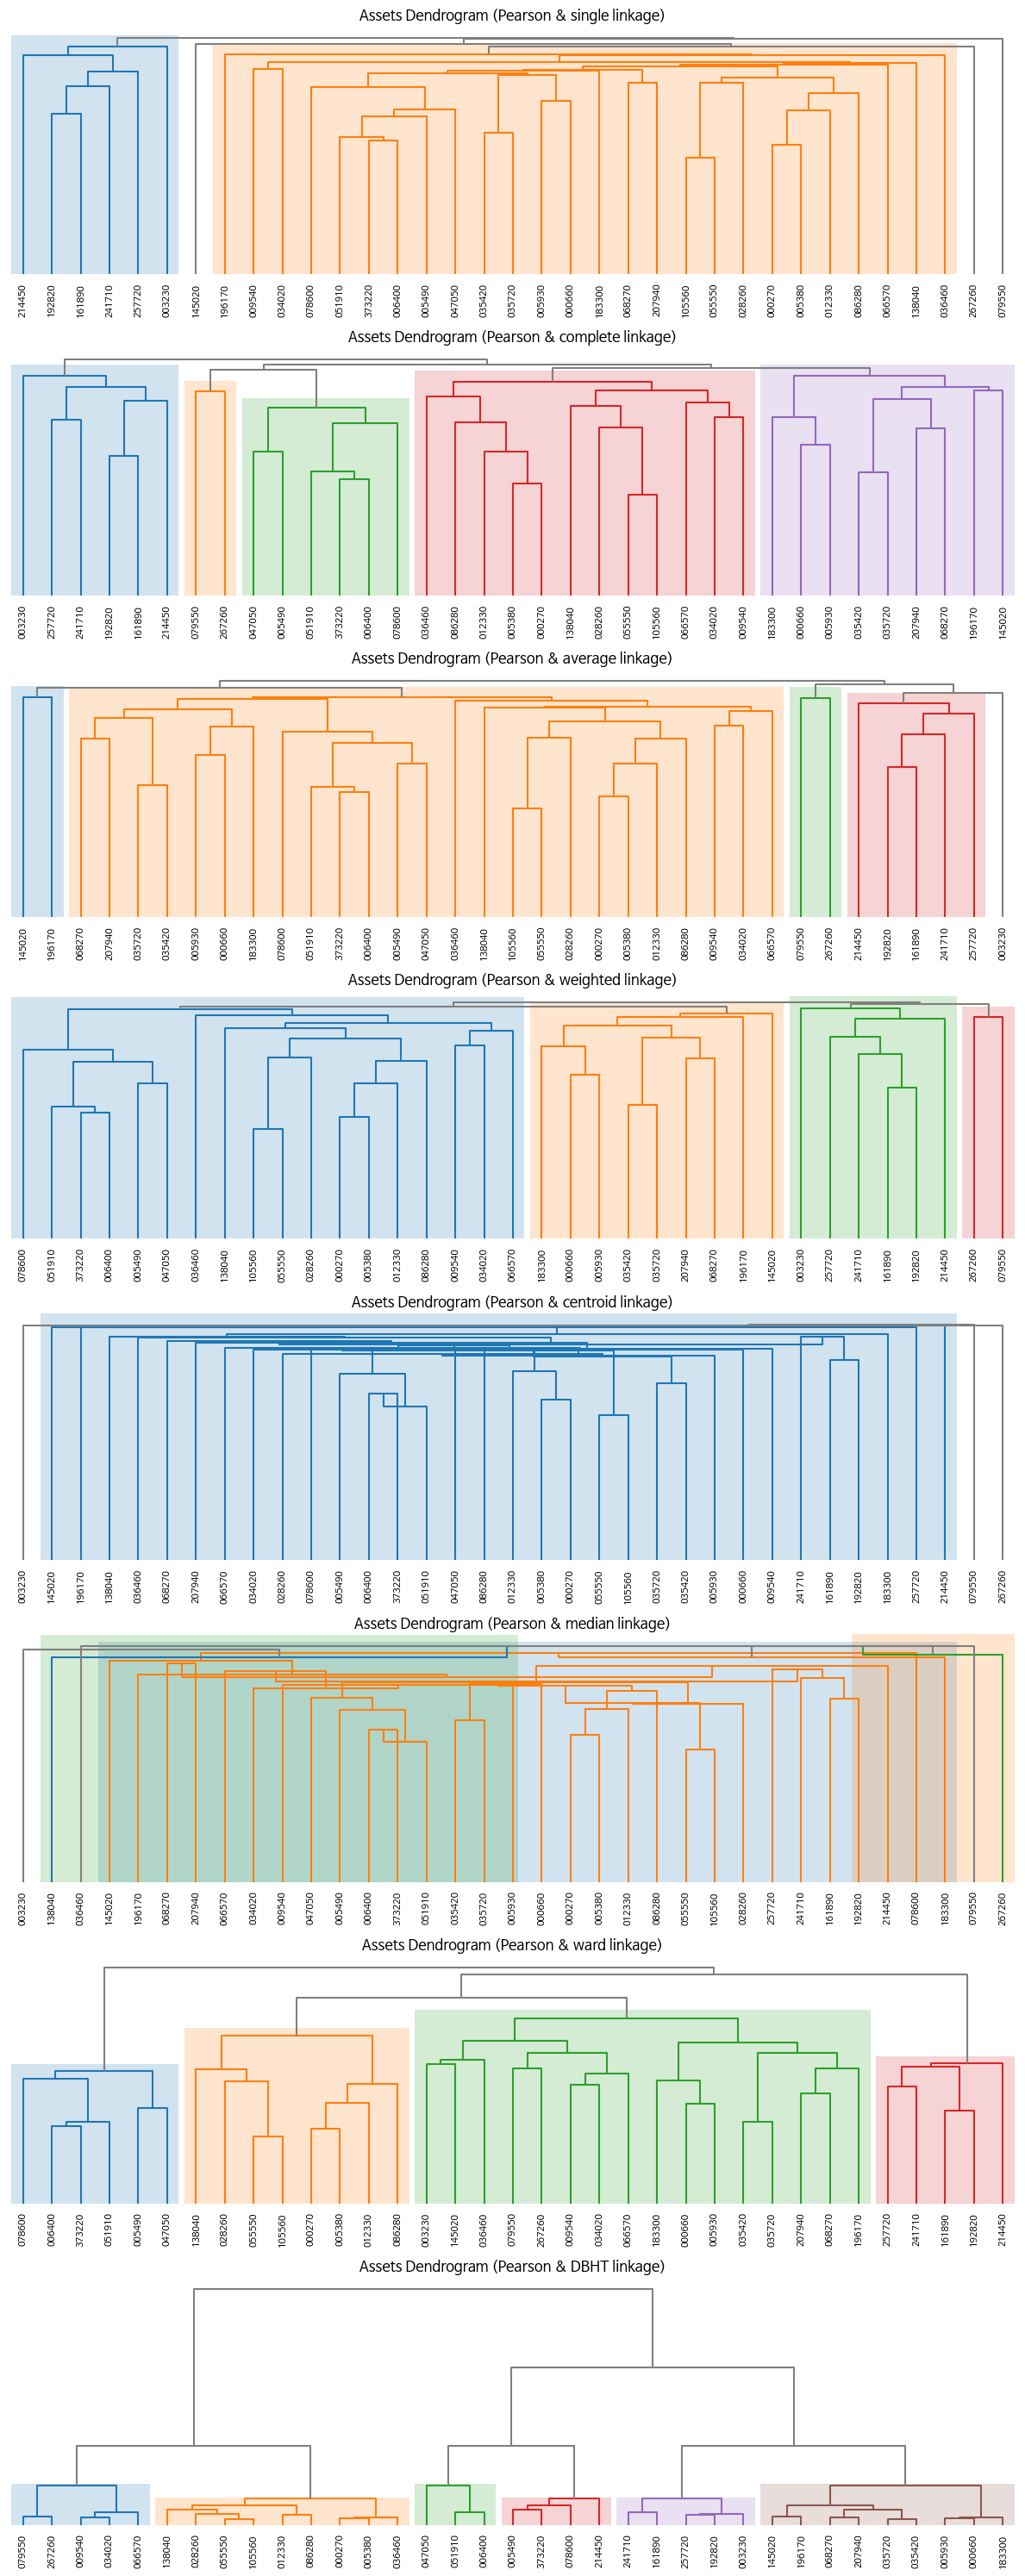

In [ ]:
import riskfolio as rp

prices = {}
for ticker in filtered_active_etf_pdf.index:
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    prices[ticker] = df['종가'].values

returns = pd.DataFrame(prices).pct_change().dropna()
linkages = ['single','complete','average','weighted',
            'centroid', 'median', 'ward','DBHT'] ## 라이브러리 내의 8가지 방식의 linkage 조절 가능

fig, ax = plt.subplots(len(linkages), 1, figsize=(12, 30))
ax = np.ravel(ax)

j = 0
for i in linkages:
    ax[j] = rp.plot_dendrogram(returns=returns,
                               codependence='pearson',
                               linkage=i,
                               k=None,
                               max_k=10,
                               leaf_order=True,
                               ax=ax[j])
    j += 1

plt.plot() ## 출력 결과, 'ward'와 'DBHT' 방식이 가장 군집화가 잘 됨을 확인

[]

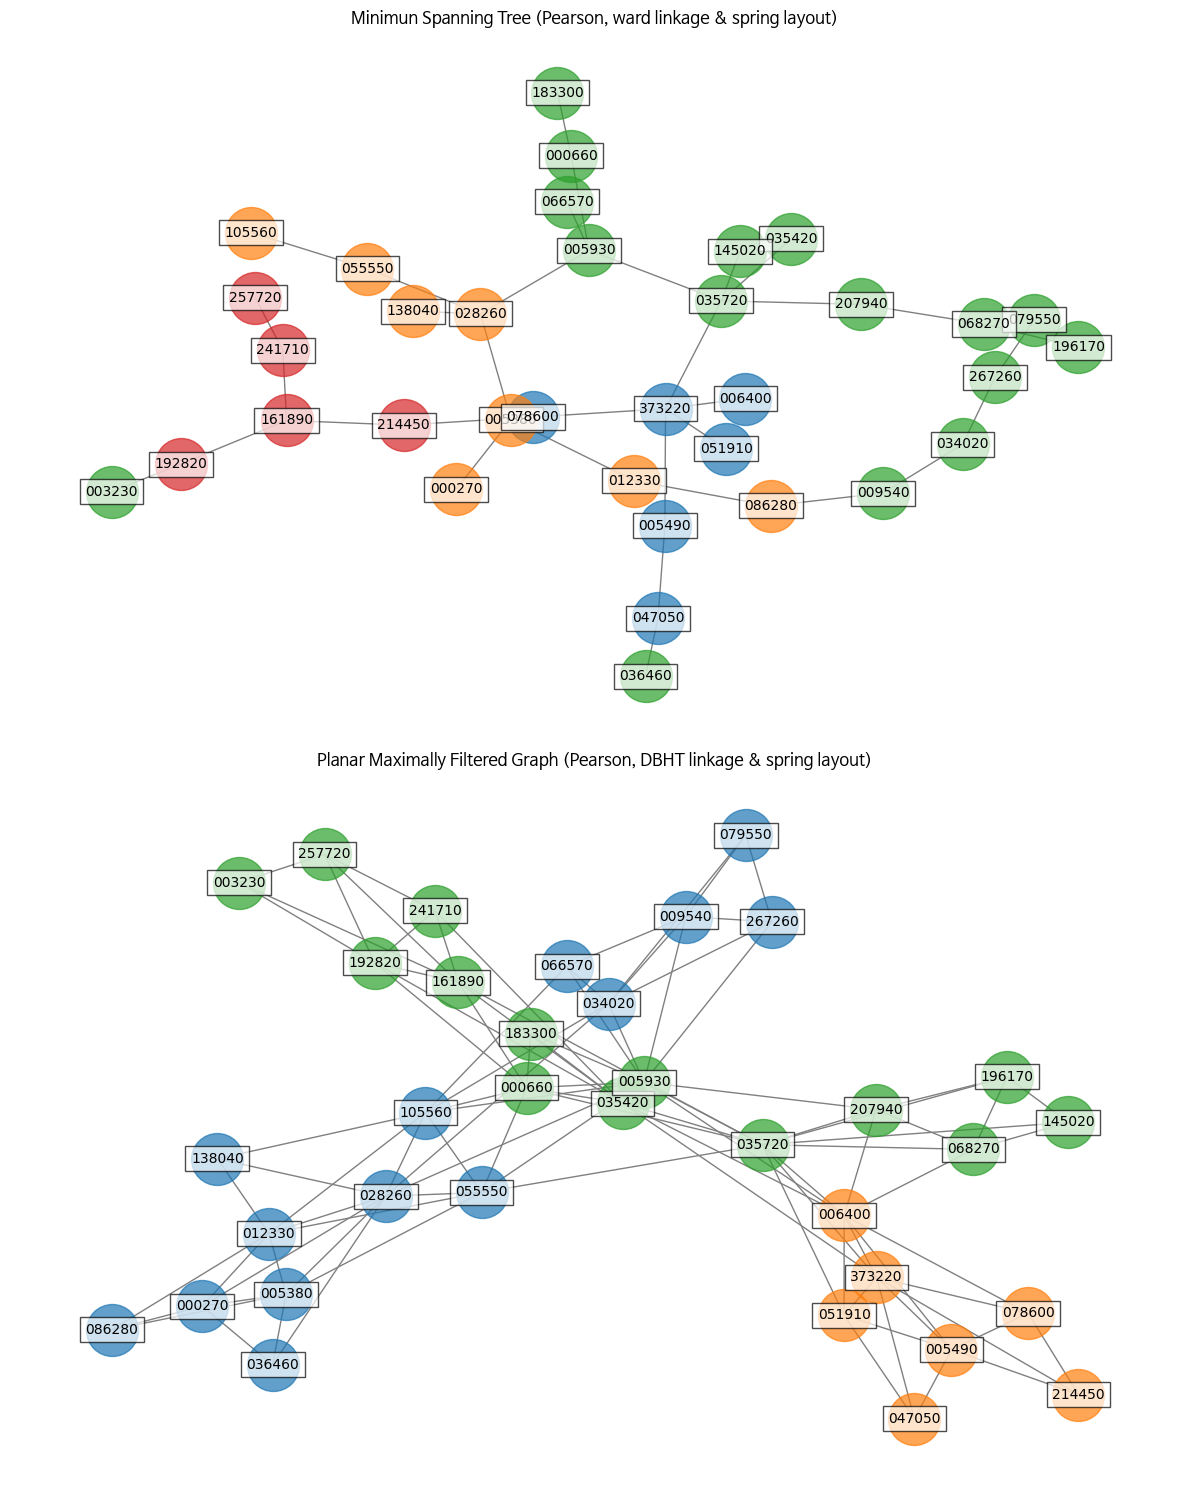

In [ ]:
# 그래프 형태로도 출력 가능

linkages = ['ward','DBHT']

fig, ax = plt.subplots(len(linkages), 1, figsize=(12, 15))
ax = np.ravel(ax)

j = 0
for i in linkages:
    ax[j] = rp.plot_network(returns=returns,
                            codependence="pearson",
                            linkage=i,
                            k=None,
                            max_k=10,
                            leaf_order=True,
                            kind='spring',
                            seed=0,
                            ax=ax[j])
    j += 1

plt.plot() ## DBHT가 좀 더 클러스터링이 잘 된 느낌

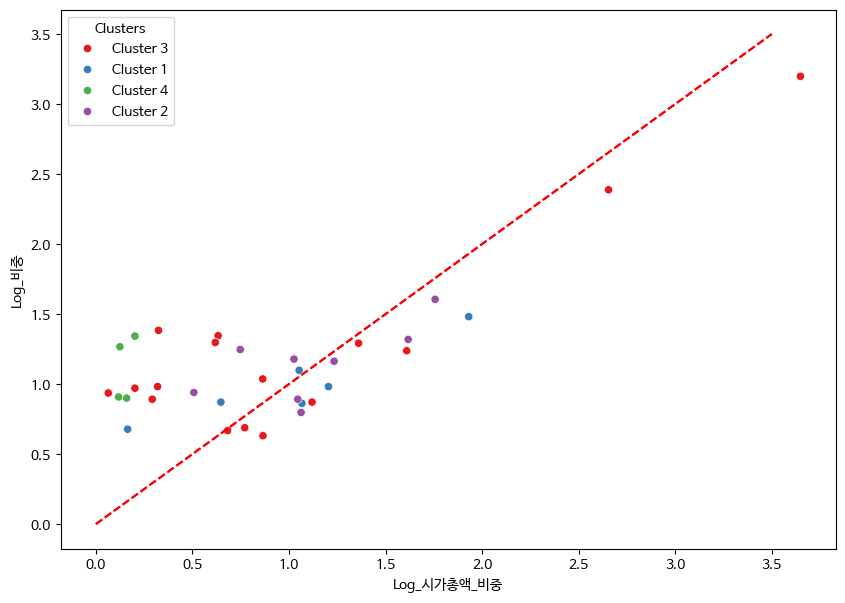

In [ ]:
## 최종 결과물 출력
clusters = rp.assets_clusters(returns=returns,
                              codependence='pearson',
                              linkage='ward',
                              k=None,
                              max_k=10,
                              leaf_order=True)

test3 = filtered_active_etf_pdf.merge(clusters, left_index=True, right_on='Assets', how='left').drop(columns='Assets')

plt.figure(figsize=(10, 7))
sns.scatterplot(data=test3, y='Log_비중', x='Log_시가총액_비중', hue='Clusters', palette='Set1')

y_x_values = np.linspace((0,0),(3.5,3.5))
plt.plot(y_x_values, y_x_values, color='red', linestyle='--')

### IDEA4. ARIMA 모델의 잔차 기반 클러스터링
- 가격 데이터를 곧바로 모델에 집어넣는 것이 아닌, 시계열 모델로 1차 추정을 한 뒤의 잔차항을 대입
- 이후의 모델 자체의 골자는 동일(DBSCAN으로도 클러스터링 시도)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


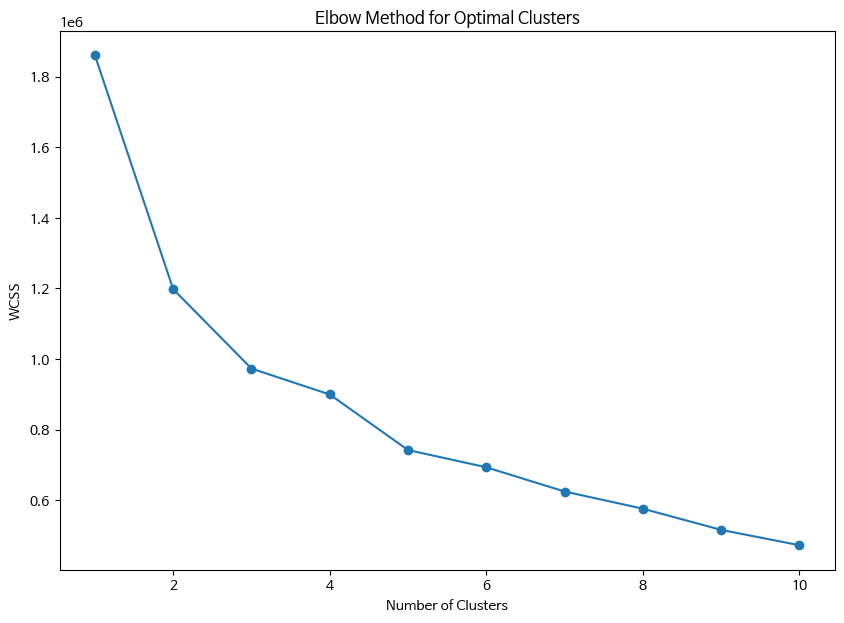

Clustered DataFrame:
           계약수         금액     비중             시가총액    시가총액_비중  ActiveWeight  \
티커                                                                           
003230    49.0   32781000   2.99    4986855930000   0.383038      2.606962   
257720   629.0   29563000   2.83    2918871570300   0.224197      2.605803   
267260    96.0   29760000   2.84   11499036065000   0.883235      1.956765   
196170    36.0   10098000   0.99   15120756216000   1.161417     -0.171417   
241710   192.0   16224000   1.56     890712000000   0.068415      1.491585   
078600    67.0    9581000   0.97    2328281187200   0.178834      0.791166   
047050   221.0   14453400   1.39   11857195911200   0.910745      0.479255   
005490    47.0   17061000   1.67   30403357185000   2.335266     -0.665266   
161890   374.0   26628800   2.55    1723170621000   0.132356      2.417644   
009540   173.0   27472400   2.66   11146765770000   0.856177      1.803823   
183300   197.0   15819100   1.55     863006

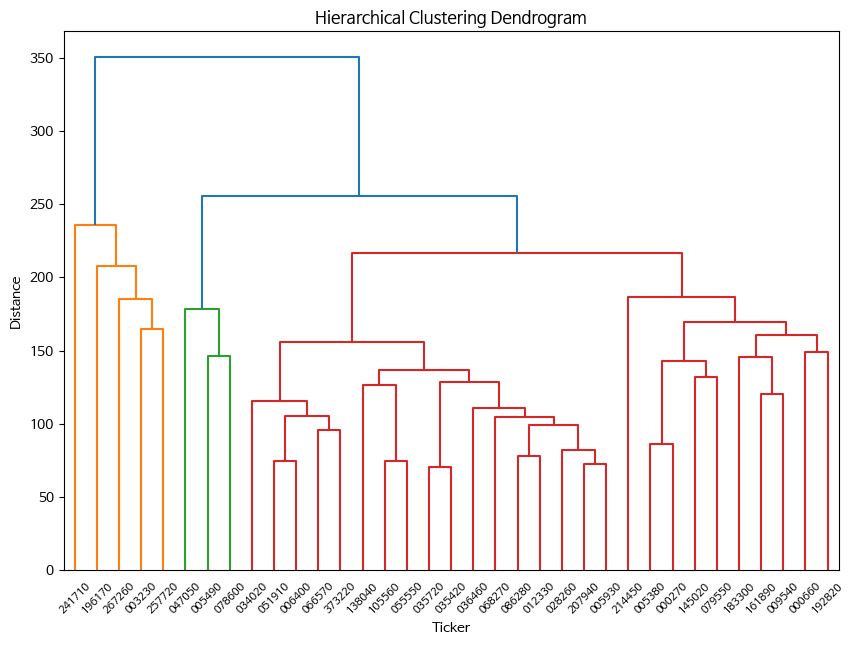

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler

prices = {}
for ticker in filtered_active_etf_pdf.index:
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    model = ARIMA(df['종가'], order=(1, 1, 1)) ## ARIMA(1,1,1)로 모델링
    model_fit = model.fit()
    prices[ticker] = model_fit.resid.values

# 주가 데이터 정규화
scaler = StandardScaler()
normalized_prices = {ticker: scaler.fit_transform(price.reshape(-1, 1)).flatten() for ticker, price in prices.items()}

# 동적 시간 왜곡을 이용한 거리 계산
tickers = list(normalized_prices.keys())
distance_matrix = np.zeros((len(tickers), len(tickers)))

for i in range(len(tickers)):
    for j in range(i, len(tickers)):
        if i != j:
            distance, _ = fastdtw(normalized_prices[tickers[i]], normalized_prices[tickers[j]])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

# 클러스터링 수행
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# 엘보우 방법을 사용하여 최적의 클러스터 수 찾기
def calculate_wcss(linkage_matrix, max_clusters=10):
    wcss = []
    for t in range(1, max_clusters + 1):
        clusters = fcluster(linkage_matrix, t=t, criterion='maxclust')
        centroids = []
        for cluster in range(1, t + 1):
            cluster_points = [distance_matrix[i] for i in range(len(clusters)) if clusters[i] == cluster]
            centroid = np.mean(cluster_points, axis=0)
            centroids.append(centroid)
        total_distance = 0
        for i in range(len(clusters)):
            cluster = clusters[i]
            centroid = centroids[cluster - 1]
            total_distance += np.sum((distance_matrix[i] - centroid) ** 2)
        wcss.append(total_distance)
    return wcss

wcss = calculate_wcss(linkage_matrix)

# 엘보우 방법 그래프 시각화
plt.figure(figsize=(10, 7))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# 최적의 클러스터 수 자동 결정
optimal_clusters = np.argmin(np.diff(wcss, 2)) + 2

# 최적의 클러스터 수를 사용하여 클러스터 할당
clusters = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')
filtered_active_etf_pdf['Cluster'] = clusters

# 클러스터 및 ActiveWeight를 기준으로 정렬
filtered_active_etf_pdf = filtered_active_etf_pdf.sort_values(by=['Cluster', 'ActiveWeight'], ascending=[True, False])

# 클러스터 결과 출력
print("Clustered DataFrame:")
print(filtered_active_etf_pdf)

# 덴드로그램 시각화
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=tickers)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Ticker')
plt.ylabel('Distance')
plt.show()

Top Stocks per Cluster:
       티커  Cluster  ActiveWeight           시가총액    비중   시가총액_비중
0  003230        1      2.606962  4986855930000  2.99  0.383038
1  241710        2      1.491585   890712000000  1.56  0.068415
2  078600        3      0.791166  2328281187200  0.97  0.178834
3  161890        4      2.417644  1723170621000  2.55  0.132356


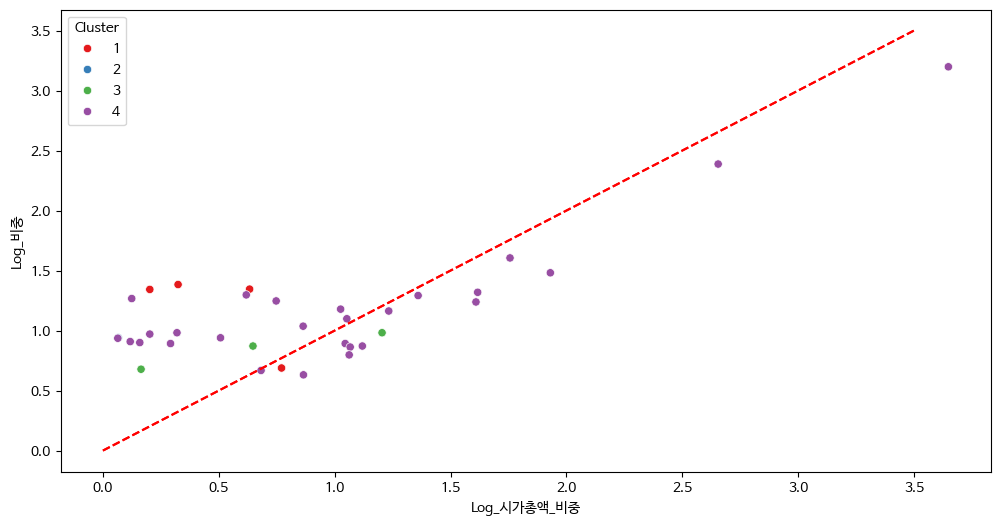

In [ ]:
# 각 클러스터별로 ActiveWeight가 가장 높은 종목 추출
top_stocks_per_cluster = filtered_active_etf_pdf.groupby('Cluster').head(1).reset_index()

# 결과 출력
print("Top Stocks per Cluster:")
print(top_stocks_per_cluster[['티커', 'Cluster', 'ActiveWeight', '시가총액', '비중', '시가총액_비중']])

plt.figure(figsize=(12,6))
sns.scatterplot(data=filtered_active_etf_pdf, y='Log_비중', x='Log_시가총액_비중', hue='Cluster', palette='Set1')

y_x_values = np.linspace((0,0),(3.5,3.5))
plt.plot(y_x_values, y_x_values, color='red', linestyle='--')

In [ ]:
## 위의 클러스터링 결과는 특정 군집으로(4번) 다소 편향됨. DBSCAN으로 클러스터링 재진행

In [ ]:
from sklearn.cluster import DBSCAN

prices = {}
for ticker in filtered_active_etf_pdf.index:
    df = stock.get_market_ohlcv_by_date("20230101", today, ticker)
    model = ARIMA(df['종가'], order=(1, 1, 1)) ## ARIMA(1,1,1)로 모델링
    model_fit = model.fit()
    prices[ticker] = model_fit.resid.values

resid_df = pd.DataFrame(prices)

scaler = StandardScaler()
scaled_resid = scaler.fit_transform(resid_df)

dbscan = DBSCAN(eps=10, min_samples=3)
clusters = dbscan.fit_predict(scaled_resid.T)

filtered_active_etf_pdf['Cluster'] = clusters
filtered_active_etf_pdf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,계약수,금액,비중,시가총액,시가총액_비중,ActiveWeight,Log_비중,Log_시가총액_비중,Cluster,HurstExponent
티커,,,,,,,,,,
003230,49.0,32781000,2.99,4986855930000,0.383038,2.606962,1.383791,0.324282,-1,0.612891
257720,629.0,29563000,2.83,2918871570300,0.224197,2.605803,1.342865,0.202285,-1,0.560151
267260,96.0,29760000,2.84,11499036065000,0.883235,1.956765,1.345472,0.632991,-1,0.448083
196170,36.0,10098000,0.99,15120756216000,1.161417,-0.171417,0.688135,0.770764,-1,0.571258
241710,192.0,16224000,1.56,890712000000,0.068415,1.491585,0.940007,0.066176,-1,0.498018
078600,67.0,9581000,0.97,2328281187200,0.178834,0.791166,0.678034,0.164526,-1,0.525405
047050,221.0,14453400,1.39,11857195911200,0.910745,0.479255,0.871293,0.647493,-1,0.548921
005490,47.0,17061000,1.67,30403357185000,2.335266,-0.665266,0.982078,1.204552,-1,0.532505
161890,374.0,26628800,2.55,1723170621000,0.132356,2.417644,1.266948,0.124300,-1,0.492396


Top Stocks per Cluster:
       티커  Cluster  ActiveWeight            시가총액    비중   시가총액_비중
0  003230       -1      2.606962   4986855930000  2.99  0.383038
1  138040        0      1.368133  14475656652600  2.48  1.111867


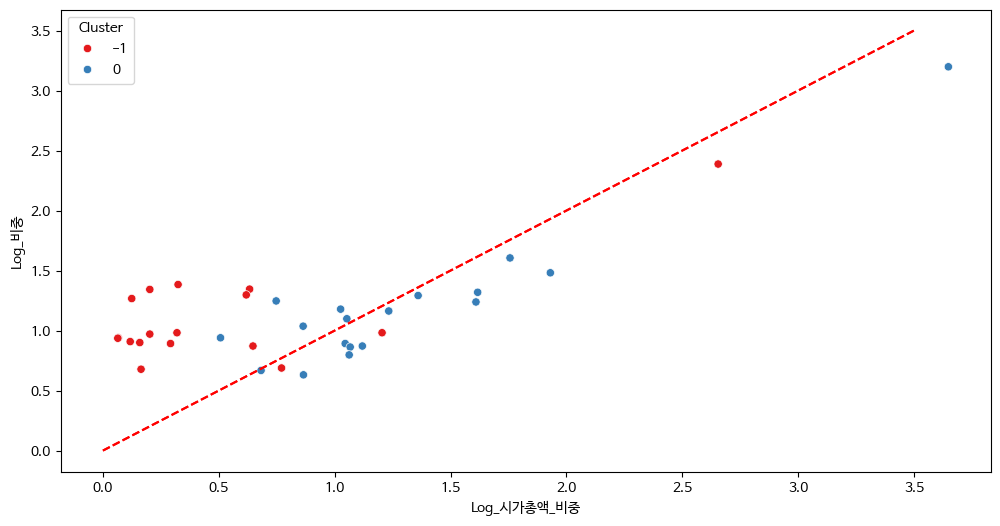

In [ ]:
# 각 클러스터별로 ActiveWeight가 가장 높은 종목 추출
top_stocks_per_cluster = filtered_active_etf_pdf.groupby('Cluster').head(1).reset_index()

# 결과 출력
print("Top Stocks per Cluster:")
print(top_stocks_per_cluster[['티커', 'Cluster', 'ActiveWeight', '시가총액', '비중', '시가총액_비중']])

plt.figure(figsize=(12,6))
sns.scatterplot(data=filtered_active_etf_pdf, y='Log_비중', x='Log_시가총액_비중', hue='Cluster', palette='Set1')

y_x_values = np.linspace((0,0),(3.5,3.5))
plt.plot(y_x_values, y_x_values, color='red', linestyle='--')